In [32]:
# --- Imports ---
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Chargement des données ---
# On charge la matrice creuse (sparse)
X = load_npz('./out/user_permission_matrix_sparse.npz')

# On charge les catalogues pour savoir à quoi correspondent les lignes et colonnes
apps_df = pd.read_csv('./out/app_catalog.csv')
users_df = pd.read_csv('./out/users_catalog.csv')
perms_df = pd.read_csv('./out/perm_catalog.csv')
full_users_df = pd.read_csv('./iam_dataset/users.csv') # On charge aussi les détails des utilisateurs

# --- Vérification ---
# X.shape doit correspondre à (nombre d'utilisateurs, nombre de permissions)
print("Shape de la matrice :", X.shape)
print("Nombre d'utilisateurs dans le catalogue :", len(users_df))
print("Nombre de permissions dans le catalogue :", len(perms_df))

Shape de la matrice : (5000, 324)
Nombre d'utilisateurs dans le catalogue : 5000
Nombre de permissions dans le catalogue : 324


Calcul pour K=2 terminé.
Calcul pour K=3 terminé.
Calcul pour K=4 terminé.
Calcul pour K=5 terminé.
Calcul pour K=6 terminé.
Calcul pour K=7 terminé.
Calcul pour K=8 terminé.
Calcul pour K=9 terminé.
Calcul pour K=10 terminé.
Calcul pour K=11 terminé.
Calcul pour K=12 terminé.
Calcul pour K=13 terminé.
Calcul pour K=14 terminé.
Calcul pour K=15 terminé.
Calcul pour K=16 terminé.
Calcul pour K=17 terminé.
Calcul pour K=18 terminé.
Calcul pour K=19 terminé.
Calcul pour K=20 terminé.
Calcul pour K=21 terminé.
Calcul pour K=22 terminé.
Calcul pour K=23 terminé.
Calcul pour K=24 terminé.
Calcul pour K=25 terminé.
Calcul pour K=26 terminé.
Calcul pour K=27 terminé.
Calcul pour K=28 terminé.
Calcul pour K=29 terminé.
Calcul pour K=30 terminé.


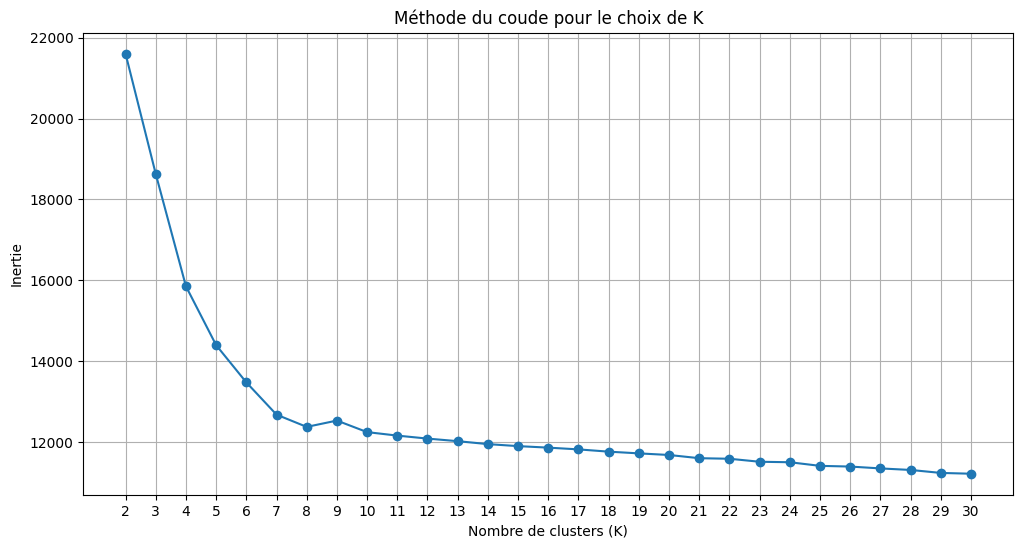

In [33]:
# Méthode du coude pour trouver le K optimal
inertia = []
K_range = range(2, 31) # On teste K de 2 à 30 rôles

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' dans les versions récentes
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    print(f"Calcul pour K={k} terminé.")

# On affiche le graphique
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour le choix de K")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [34]:
# On choisit la valeur de K identifiée grâce au coude
CHOSEN_K = 8 

# On entraîne le modèle final
model = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10)
model.fit(X)

# On récupère les labels (le rôle assigné à chaque utilisateur)
user_roles = model.labels_

# On ajoute ces rôles à notre dataframe d'utilisateurs
users_df['role_id'] = user_roles
print("Aperçu des utilisateurs avec leur rôle assigné :")
print(users_df.head())

Aperçu des utilisateurs avec leur rôle assigné :
   user_id  role_id
0        1        3
1        2        5
2        3        0
3        4        1
4        5        6


In [38]:
# --- Analyse du Rôle ---
for k in range (CHOSEN_K):
    ROLE_TO_ANALYZE = k
    
    # 1. QUI SONT LES UTILISATEURS DE CE RÔLE ?
    # On filtre pour ne garder que les utilisateurs du rôle 5
    role_users = users_df[users_df['role_id'] == ROLE_TO_ANALYZE]
    
    # On joint avec les informations complètes des utilisateurs pour en savoir plus sur eux
    role_users_details = role_users.merge(full_users_df, on='user_id')
    
    print(f"--- Analyse du Rôle n°{ROLE_TO_ANALYZE} ---")
    print(f"Nombre d'utilisateurs dans ce rôle : {len(role_users_details)}")
    print("\nRépartition par poste :")
    print(role_users_details['position'].value_counts())
    print("\nRépartition par département :")
    print(role_users_details['department'].value_counts())
    
    
    # 2. QUELLES SONT LEURS PERMISSIONS COMMUNES ?
    # On récupère les permissions "centrales" de ce cluster (le centroïde)
    # Une valeur élevée signifie que cette permission est importante pour ce rôle
    center = model.cluster_centers_[ROLE_TO_ANALYZE]
    
    # On récupère les 10 permissions les plus importantes pour ce rôle
    top_10_perm_indices = center.argsort()[-10:][::-1]
    top_perms = perms_df.iloc[top_10_perm_indices]
    
    
    # On joint 'top_perms' avec 'apps_df' en utilisant la colonne commune 'application_id'
    top_perms_with_app_names = pd.merge(top_perms, apps_df, on='application_id', how='left')
    
    
    print("\nTop 10 permissions pour ce rôle :")
    # On affiche le nouveau DataFrame fusionné
    print(
        top_perms_with_app_names[[
            'perm_name',
            'app_name'
        ]].to_string(index=False)
    )


--- Analyse du Rôle n°0 ---
Nombre d'utilisateurs dans ce rôle : 1325

Répartition par poste :
position
Architect            206
Security Engineer    198
IT Support           195
DBA                  194
Dev                  183
DevOps               178
Sysadmin             171
Name: count, dtype: int64

Répartition par département :
department
Department IT    1325
Name: count, dtype: int64

Top 10 permissions pour ce rôle :
        perm_name           app_name
  manage_pipeline  GitHub Enterprise
            login CrowdStrike Falcon
      open_ticket    ServiceNow ITSM
    open_employee         Talentsoft
manage_identities CrowdStrike Falcon
            login  GitHub Enterprise
  manage_pipeline         Confluence
    read_messages         SharePoint
   create_channel         SharePoint
      manage_team         SharePoint
--- Analyse du Rôle n°1 ---
Nombre d'utilisateurs dans ce rôle : 548

Répartition par poste :
position
Engineer      188
Researcher    181
Scientist     179
Name: 